In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import wave
from scipy.signal import hilbert, chirp

In [2]:
angry="./Audio_Speech_Actors_01-24/Actor_11/03-01-05-02-01-02-11.wav"
happy="./Audio_Speech_Actors_01-24/Actor_11/03-01-02-02-01-02-11.wav"
angry_file=wave.open(angry,'r') #file read
angry_data=angry_file.readframes(angry_file.getnframes())
print "angry duration=",angry_file.getnframes()/(1.0*angry_file.getframerate()),"s"
print "framerate=",angry_file.getframerate()
angry_framerate=angry_file.getframerate()
angry_frames=angry_file.getnframes()
print "number of frames=",angry_frames
print ""
angry_file.close()
happy_file=wave.open(happy,'r') #file read
happy_data=happy_file.readframes(happy_file.getnframes())
print "happy duration=",happy_file.getnframes()/(1.0*happy_file.getframerate()),"s"
print "framerate=",happy_file.getframerate()
happy_framerate=happy_file.getframerate()
happy_frames=happy_file.getnframes()
print "number of frames=",happy_frames
print ""
happy_file.close()

angry duration= 3.970625 s
framerate= 48000
number of frames= 190590

happy duration= 3.73708333333 s
framerate= 48000
number of frames= 179380



In [3]:
angry_data=struct.unpack('{n}h'.format(n=angry_frames),angry_data)
happy_data=struct.unpack('{n}h'.format(n=happy_frames),happy_data)

In [4]:
angry_data=np.array(angry_data)
happy_data=np.array(happy_data)
ratechange=8
angry_datar=np.array([angry_data[i] for i in range(0,angry_data.size,ratechange)]) #data_reduced has reduced frame rate
#new data has frame rate of 48000/6=8000
framerateN=angry_framerate/ratechange
happy_datar=np.array([happy_data[i] for i in range(0,happy_data.size,ratechange)]) #data_reduced has reduced frame rate
#new data has frame rate of 48000/6=8000

In [5]:
happy_fft=np.fft.fft(happy_datar)
angry_fft=np.fft.fft(angry_datar)

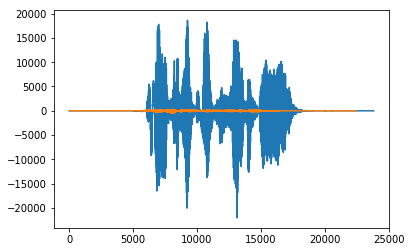

In [6]:
plt.plot(angry_datar)
plt.plot(happy_datar)

### Plots of original FFT's

Happy FFT

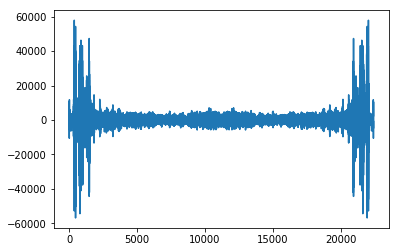

In [7]:
plt.plot(np.real(happy_fft))

Angry FFT

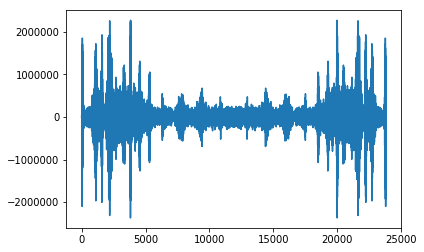

In [8]:
plt.plot(np.real(angry_fft))

#### Window required Later

Window Size is 5ms

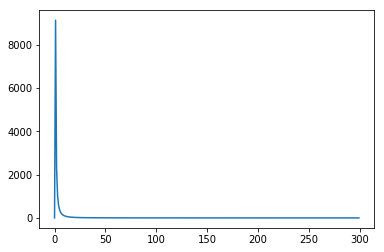

In [9]:
window_size=framerateN*5/100 #5ms window => framerateN*[(5/100)s] window size
window=np.array([1/(2*np.sin(np.pi*n/(2*window_size)))**2 for n in range(1,window_size)])
window=np.concatenate(([0.0],window),axis=0)
window
plt.plot(window)

### ZFR function

In [10]:
##ZFR y1[n]=2*y1[n-1]-y1[n-2]+data[n]
def ZFR(y,data): ##
    y[0]=data[0]
    y[1]=data[1]+2*y[0]
    for n in range(2,data.size):
        y[n]=2*y[n-1]-y[n-2]+data[n]
    #plt.plot(y)
    return y

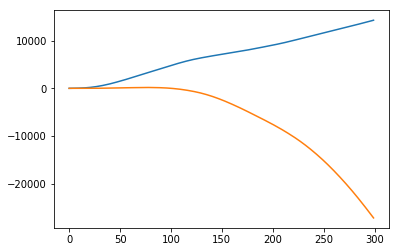

In [11]:
y1a=np.zeros(window_size)
y1h=np.zeros(window_size)
p=10
testinga=angry_datar[window_size*p:window_size*(p+1)]
testingh=happy_datar[window_size*(p):window_size*(p+1)]
ZFR(y1a,testinga)
ZFR(y1h,testingh)
plt.plot(y1a)
plt.plot(y1h)
#plt.plot(angry_datar[window_size*p:window_size*(p+1)])
#plt.plot(angry_datar[window_size*(p+1):window_size*(p+2)])

#### ZFR Applied twice

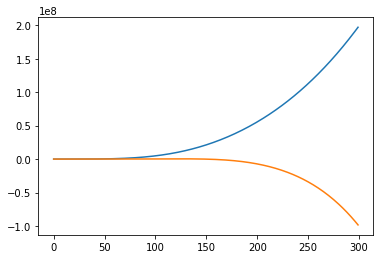

In [12]:
y2a=np.zeros(window_size)
y2h=np.zeros(window_size)
ZFR(y2a,y1a)
ZFR(y2h,y1h)
plt.plot(y2a)
plt.plot(y2h)

In [13]:
# ZFF : y[n]=y2[n]-(1/2P+1)*summationk(n-p,n+p)data[k]
def ZFF(x):
    num_samples=x.size
    y=np.zeros(num_samples)
    ya=np.zeros(num_samples)
    P=int(framerateN/100)   ##"frames" number of frames per second and .01 sec => this much number of frames #100 hz#np.abs(np.fft.fft(x)).mean() ## average pitch period ???? unable to figure out
    for n in range(num_samples):
        a=0
        for k in range(max(0,n-P),min(n+P,num_samples)):
            a+=x[k]
        ya[n]=a/(2*P+1.0)
        y[n]=x[n]-ya[n]
    return np.array(y)

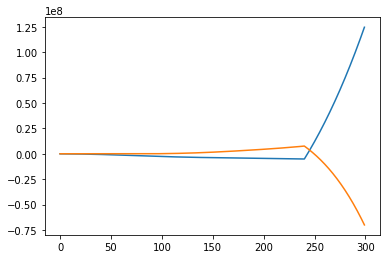

In [14]:
ya=ZFF(y2a)
yh=ZFF(y2h)
plt.plot(ya)
plt.plot(yh)

In [15]:
#plt.subplot(2,1,1)
#fft_data=np.fft.rfft(testing*window)
#plt.plot(np.log10(np.real(fft_data)*1.0/np.abs(fft_data).max()))
#plt.subplot(4,1,2)
#plt.plot(np.abs(np.fft.fft(y1)))
#plt.subplot(4,1,3)
#plt.plot(np.abs(np.fft.fft(y2)))
#plt.subplot(2,1,2)
#fft=np.fft.rfft(y)
#plt.plot(np.log10(np.abs(fft)/np.abs(fft).max()))
#print np.argmax(fft/fft.max())

In [16]:
def NGD(x):
    a=np.array([i for i in range(x.size)])
    y=x*a
    dftx=np.fft.fft(x)
    dfty=np.fft.fft(y)
    z=np.real(dftx)*np.real(dfty)+np.imag(dftx)*np.imag(dfty)
    return z
    

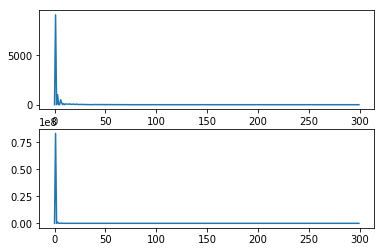

In [17]:
#yw1=wnd(testing)
plt.subplot(2,1,1)
plt.plot(testinga*window)
plt.subplot(2,1,2)
yw2a=(testinga*window*window)
plt.plot(yw2a) ## sharper peak
ngddataa=NGD(testinga)
ngdyw2a=NGD(yw2a)

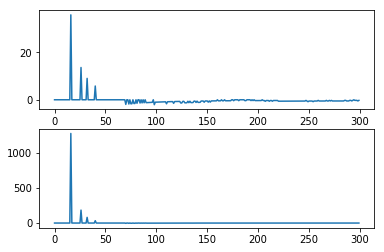

In [18]:
#yw1=wnd(testingh)
plt.subplot(2,1,1)
plt.plot(testingh*window)
plt.subplot(2,1,2)
yw2h=(testingh*window*window)
plt.plot(yw2h) ## sharper peak
ngddatah=NGD(testingh)
ngdyw2h=NGD(yw2h)

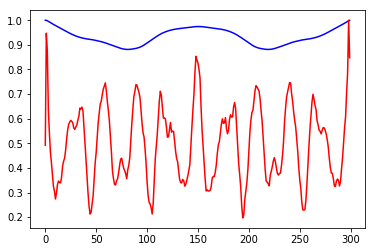

In [19]:
fig=plt.figure()
ax0=fig.add_subplot(111)
hilbert_testa=hilbert(ngdyw2a)
hilbert_testh=hilbert(ngdyw2h)
plt.plot(np.real(hilbert_testa/hilbert_testa.max()),label="angry",color="blue")
plt.plot(np.real(hilbert_testh/hilbert_testh.max()),label="calm",color="red")
#ax0.plot(np.real(ngdyw2))
plt.savefig("./actor 11.png")